The dataset of car license plates contains 433 images with bounding box annotations of the number plates within the image. The goal of this project is to train a convolutional neural network capable of locating licenses plate on new images, reading the number on the plate and detecting the license plate on videos.

In [8]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [10]:
pip install keras-tuner

In [11]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob
from bs4 import BeautifulSoup
from time import perf_counter
import tensorflow as tf
from PIL import Image
import pytesseract
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import kerastuner as kt
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


Reading the image and annotation from the respective path

In [12]:
image_path = '/content/gdrive/MyDrive/plate data/images'
annotation_path = '/content/gdrive/MyDrive/plate data/annotations'

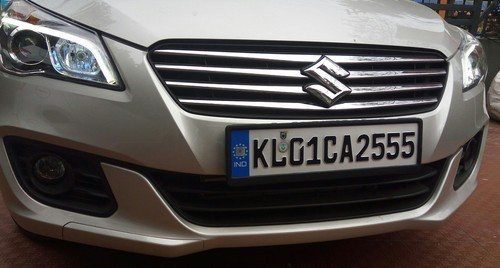

In [13]:
images = os.listdir(image_path)
images.sort()
annotations = os.listdir(annotation_path)
annotations.sort()
Image.open(os.path.join(image_path,images[0]))

In [14]:
X=[]
image_size = 256
for f in images:
    img = cv2.imread(os.path.join(image_path,f))
    img = cv2.resize(img, (image_size,image_size))
    X.append(np.array(img))

In [15]:
#Scraping XML file for getting the boundary for license plate
def resize_annotation(file):
    with open(file, 'r') as f:
        data = f.read()
    
    Bs_data = BeautifulSoup(data, "xml")
    
    width = int(Bs_data.find('width').text)
    height = int(Bs_data.find('height').text)
    xmin = int(Bs_data.find('xmin').text)
    ymin = int(Bs_data.find('ymin').text)
    xmax = int(Bs_data.find('xmax').text)
    ymax = int(Bs_data.find('ymax').text)
    
    #below will resize the bounding boxes equivalent to (changes made in image)/image resize.
    xmin = xmin/(width/image_size)
    ymin = ymin/(height/image_size)
    xmax = xmax/(width/image_size)
    ymax = ymax/(height/image_size)
        
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [16]:
print(resize_annotation(os.path.join(annotation_path,annotations[0])))

[214, 165, 115, 119]


In [17]:
y=[]
for f in annotations:
    y.append(resize_annotation(os.path.join(annotation_path,f)))

In [18]:
#checking shape of the arrays ,both must have same length
print(np.array(X).shape,np.array(y).shape)

(433, 256, 256, 3) (433, 4)


The first 6 images of the dataset are shown below :

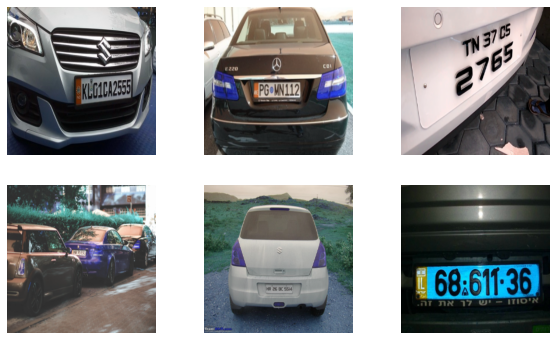

In [19]:
plt.figure(figsize=(10,6))
for i in range(0,6) :
    plt.subplot(2,3,i+1)
    plt.axis('off')
    plt.imshow(X[i])

Original image with Boundary ->


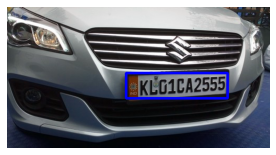

Cropped image ->


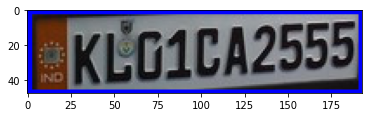

Reading image ->
KEG1CA2555

Original image with Boundary ->


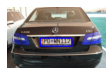

Cropped image ->


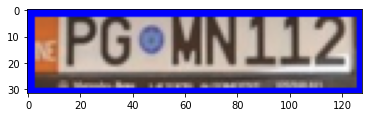

Reading image ->

Original image with Boundary ->


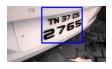

Cropped image ->


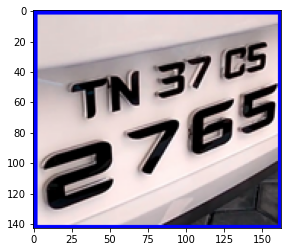

Reading image ->
57 Ee"

Original image with Boundary ->


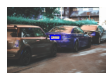

Cropped image ->


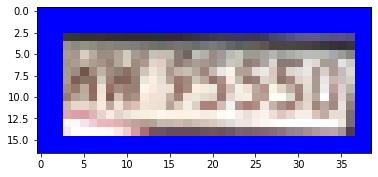

Reading image ->

Original image with Boundary ->


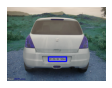

Cropped image ->


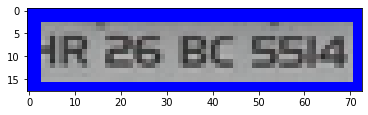

Reading image ->
(A 26 BC S5I4|

Original image with Boundary ->


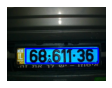

Cropped image ->


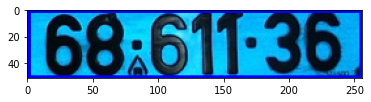

Reading image ->
168-611 36 |



In [20]:
# plotting original images with bounding boxes for just visualization
from matplotlib import pyplot as plt
plt.figure(figsize=(16,10))
for i in range(0,6) :
    img = cv2.imread(os.path.join(image_path,images[i]))
    
    with open(os.path.join(annotation_path,annotations[i]), 'r') as f:
        data = f.read()

    Bs_data = BeautifulSoup(data, "xml")

    xmin = int(Bs_data.find('xmin').text)
    ymin = int(Bs_data.find('ymin').text)
    xmax = int(Bs_data.find('xmax').text)
    ymax = int(Bs_data.find('ymax').text)

    image = cv2.rectangle(img,(xmin,ymax),(xmax,ymin),(0, 0, 255),thickness = 3)

    plt.subplot(2,3,i+1)
    plt.axis('off')
    print("Original image with Boundary ->")
    plt.imshow(image)
    plt.show()

    #Crop the image
    im2 = image.copy()
    im2_crop = im2[ymin:ymax, xmin:xmax]
    print("Cropped image ->")
    plt.imshow(im2_crop)
    plt.show()

    #Preprocessing of image
    #Converting to grayscale
    gray = cv2.cvtColor(im2_crop, cv2.COLOR_BGR2GRAY) 
    #perform thresholding
    ret,thresh1 = cv2.threshold(np.array(gray), 125, 255, cv2.THRESH_BINARY)
    #Applying tesseract
    custom_config = r'--oem 3 --psm 6'
    #config = ('-l eng --oem 1 --psm 3')
    print("Reading image ->")
    string_num = pytesseract.image_to_string(thresh1, config=custom_config)
    if(len(string_num) == 0):
        print("Can not read image")
    else:
        print(string_num)
        

Preparing the data for the Deep Learning Model :

In [21]:
#Transforming in array
X=np.array(X)
y=np.array(y)
type(X),type(y),X.dtype,y.dtype

(numpy.ndarray, numpy.ndarray, dtype('uint8'), dtype('int64'))

In [22]:
#Normalisation
X = X / 255
y = y / 255

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

# **CNN Model**

Defining Model

In [24]:
model1 = Sequential()

model1.add(Conv2D(64, (3,3), activation='relu', input_shape=(image_size,image_size,3)))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(32, (3,3), activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(16, (3,3), activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Flatten())
model1.add(Dense(128, activation="relu"))
model1.add(Dense(64, activation="relu"))
model1.add(Dense(64, activation="relu"))
model1.add(Dense(4, activation="sigmoid"))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [25]:
model1.compile(optimizer=Adam(lr=0.0005), loss="mse", metrics=['acc'])

Making a directory to save model

In [26]:
os.mkdir('/content/gdrive/MyDrive/data/model1')

Training and saving model with better accuracy

In [27]:
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/data/model1/model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
train = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1,callbacks=[checkpoint])

Epoch 1/100
10/10 [==============================] - 33s 268ms/step - loss: 0.0364 - acc: 0.5231 - val_loss: 0.0288 - val_acc: 0.4571
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/data/model1/model-001.model/assets
Epoch 2/100
10/10 [==============================] - 1s 127ms/step - loss: 0.0281 - acc: 0.5771 - val_loss: 0.0264 - val_acc: 0.4571
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/data/model1/model-002.model/assets
Epoch 3/100
10/10 [==============================] - 1s 130ms/step - loss: 0.0266 - acc: 0.5838 - val_loss: 0.0247 - val_acc: 0.5143
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/data/model1/model-003.model/assets
Epoch 4/100
10/10 [==============================] - 1s 128ms/step - loss: 0.0227 - acc: 0.6336 - val_loss: 0.0225 - val_acc: 0.4286
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/data/model1/model-004.model/assets
Epoch 5/100
10/10 [==============================] - 1s 128ms/step - loss: 0.0170 - acc: 0.

In [28]:
#Saving the model
model1.save('/content/gdrive/MyDrive/data/cnn_model.h5', overwrite=True) 

#Evaluating the model
scores = model1.evaluate(X_test,y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 74.71%


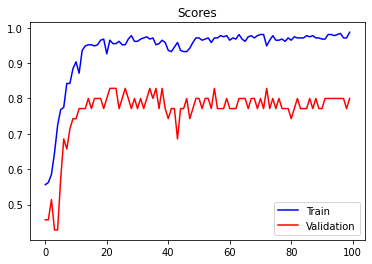

In [29]:
#Plotting the accuracy score we got while training for train and validation dataset
def plot_scores(train) :
    accuracy = train.history['acc']
    val_accuracy = train.history['val_acc']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Train')
    plt.plot(epochs, val_accuracy, 'r', label='Validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

plot_scores(train)

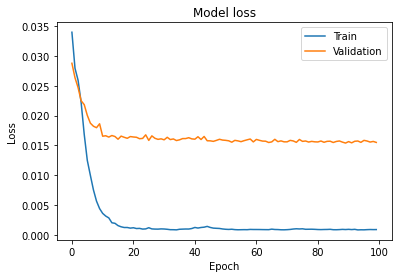

In [30]:
#Plotting the loss we got while training for train and validation dataset
def plot_loss(train):
    plt.plot(train.history['loss'])
    plt.plot(train.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

plot_loss(train)

Detection

In [31]:
test_loss, test_accuracy = model1.evaluate(X_test, y_test,steps=int(100))
print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

100/100 [==============================] - 1s 4ms/step - loss: 0.0154 - acc: 0.7471
Test results 
 Loss: 0.015398949384689331 
 Accuracy 0.7471264600753784


In [32]:
#Predicting
y_pred1 = model1.predict(X_test)

In [33]:
#Root Mean Squared Error
rmse = np.sqrt(metrics.mean_squared_error(y_pred1,y_test))
rmse

0.12409248732556923

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


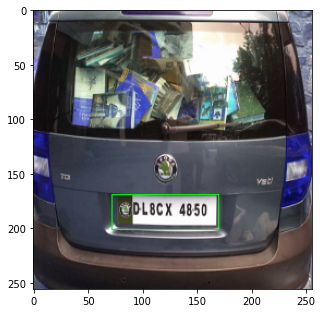

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cropped image ->


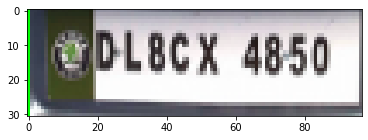

In [34]:
#The Result for test dataset after prediction
plt.figure(figsize=(5,10))
ny = y_pred1[6]*255
image = cv2.rectangle(X_test[6],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
plt.imshow(image)
plt.show()

#Number Plate crop
im2 = image.copy()
im2_crop = im2[int(ny[0]):int(ny[1]), int(ny[2]):int(ny[3])]
print("Cropped image ->")
plt.imshow(im2_crop)
plt.show()

# **VGG16 Model**

Defining the model

In [35]:
def build_cnn_vgg(hp):
    
  model = Sequential()
  model.add(Conv2D(input_shape=(image_size,image_size,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=4, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=4, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=4, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(4, activation="sigmoid"))
  
  model.compile(optimizer=Adam(
            hp.Choice('learning_rate',
                      values=[0.1, 0.01, 0.001, 0.001, 0.0001, 0.0004])), loss="mse", metrics=['acc'])

  return model

In [36]:
tune_vgg = RandomSearch(build_cnn_vgg,
                         objective="val_acc",
                         max_trials=15,
                         directory='cnn_vgg_output',
                         project_name='number plate recognition')


tune_vgg.search(X_train, y_train, verbose=1, epochs=20, validation_data=(X_val, y_val))

Trial 4 Complete [00h 01m 54s]
val_acc: 0.4571428596973419

Best val_acc So Far: 0.7142857313156128
Total elapsed time: 00h 08m 00s
INFO:tensorflow:Oracle triggered exit


In [37]:
os.mkdir('/content/gdrive/MyDrive/data/model2')

In [38]:
model =tune_vgg.get_best_models(num_models=1)[0]
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/data/model2/model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
train_vgg_tuned = model.fit(X_train,y_train, epochs=100, validation_data=(X_val,y_val), batch_size=32, verbose=2,callbacks=[checkpoint])

Epoch 1/100
10/10 - 7s - loss: 0.0044 - acc: 0.8585 - val_loss: 0.0246 - val_acc: 0.6857
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/data/model2/model-001.model/assets
Epoch 2/100
10/10 - 6s - loss: 0.0039 - acc: 0.8746 - val_loss: 0.0245 - val_acc: 0.7714
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/data/model2/model-002.model/assets
Epoch 3/100
10/10 - 6s - loss: 0.0036 - acc: 0.8585 - val_loss: 0.0240 - val_acc: 0.7429
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/data/model2/model-003.model/assets
Epoch 4/100
10/10 - 6s - loss: 0.0030 - acc: 0.8778 - val_loss: 0.0223 - val_acc: 0.5714
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/data/model2/model-004.model/assets
Epoch 5/100
10/10 - 6s - loss: 0.0030 - acc: 0.9068 - val_loss: 0.0242 - val_acc: 0.6286
Epoch 6/100
10/10 - 6s - loss: 0.0030 - acc: 0.9035 - val_loss: 0.0236 - val_acc: 0.7143
Epoch 7/100
10/10 - 6s - loss: 0.0027 - acc: 0.9035 - val_loss: 0.0239 - val_acc: 0.7714
E

In [39]:
#Saving the model
model.save('/content/gdrive/MyDrive/data/vgg_model.h5', overwrite=True) 

#Evaluating the model
scores = model.evaluate(X_test,y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 75.86%


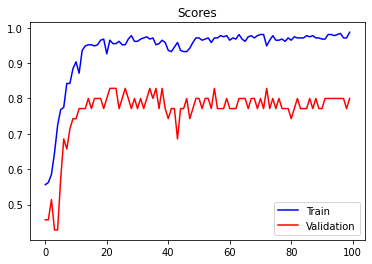

In [40]:
#Plotting the accuracy score we got while training for train and validation dataset
def plot_scores(train) :
    accuracy = train.history['acc']
    val_accuracy = train.history['val_acc']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Train')
    plt.plot(epochs, val_accuracy, 'r', label='Validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

plot_scores(train)

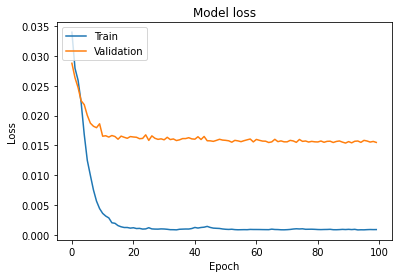

In [41]:
#Plotting the loss we got while training for train and validation dataset
def plot_loss(train):
    plt.plot(train.history['loss'])
    plt.plot(train.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_loss(train)

In [42]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))
print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

100/100 [==============================] - 2s 14ms/step - loss: 0.0238 - acc: 0.7586
Test results 
 Loss: 0.0237737987190485 
 Accuracy 0.7586206793785095


In [43]:
#Prediction
y_pred2 = model.predict(X_test)

In [44]:
#Root mean squared error
rmse = np.sqrt(metrics.mean_squared_error(y_pred2,y_test))
rmse

0.1541875406418254

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


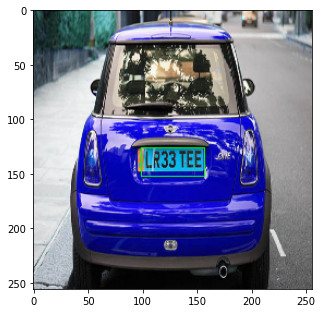

In [45]:
#The Result for test dataset after prediction
plt.figure(figsize=(5,10))
ny = y_pred2[17]*255
image = cv2.rectangle(X_test[17],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
plt.imshow(image)
plt.show()